# Practice Session 04: Weighted Networks


Reconstructing the World Trade Web using NetworkX

In [1]:
import csv
import io
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd

INPUT_NAMES_FILENAME = "./data/trade-flows/trade-countries.csv"
INPUT_TRADE= "./data/trade-flows/trade-2012-flows.csv"
YEAR = 2012

In [2]:
id2name = {}

with open(INPUT_NAMES_FILENAME, "rt") as input_file:
    reader = csv.DictReader(input_file, delimiter='\t')
    for record in reader:
        code = record['code']
        name = record['name']
        id2name[code] = name

In [3]:
g_trade = nx.DiGraph()
with open(INPUT_TRADE, "rt", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter='\t')
    for row in reader:
        frm = row['from']
        to = row['to']
        amount = round(float(row['amount'])/1000000)
        if amount > 0: 
            if frm in id2name and to in id2name:
                print(frm, to, amount)
                g_trade.add_edge(frm, to, weight = amount)
                print("edge added!")


AUS AUT 71
edge added!
AUS BEL 1434
edge added!
AUS CAN 1374
edge added!
AUS CHE 686
edge added!
AUS CHL 450
edge added!
AUS CZE 109
edge added!
AUS DEU 1679
edge added!
AUS DNK 150
edge added!
AUS ESP 487
edge added!
AUS EST 8
edge added!
AUS FIN 124
edge added!
AUS FRA 920
edge added!
AUS GBR 6621
edge added!
AUS GRC 27
edge added!
AUS HUN 12
edge added!
AUS IRL 80
edge added!
AUS ISL 4
edge added!
AUS ISR 219
edge added!
AUS ITA 806
edge added!
AUS JPN 36641
edge added!
AUS LUX 2
edge added!
AUS MEX 879
edge added!
AUS NLD 2490
edge added!
AUS NOR 53
edge added!
AUS NZL 7403
edge added!
AUS POL 65
edge added!
AUS PRT 9
edge added!
AUS SVK 3
edge added!
AUS SVN 8
edge added!
AUS SWE 357
edge added!
AUS TUR 686
edge added!
AUS USA 7916
edge added!
AUT AUS 969
edge added!
AUT BEL 2276
edge added!
AUT CAN 1030
edge added!
AUT CHE 8730
edge added!
AUT CHL 189
edge added!
AUT CZE 5715
edge added!
AUT DEU 49379
edge added!
AUT DNK 873
edge added!
AUT ESP 2413
edge added!
AUT EST 152
edge a

In [4]:
print("The {:d} graph contains {:d} nodes and {:d} edges with a total weight of {:,d} million USD".format(YEAR, g_trade.number_of_nodes(),g_trade.size(),sum(d.get("weight", 0) for u, v, d in g_trade.edges(data=True))))

The 2012 graph contains 33 nodes and 1049 edges with a total weight of 6,616,535 million USD


In [5]:
def sum_weights(graph, direction, weight_key="weight"):
    dic = dict([(n, 0) for n in graph.nodes()])
    
    for n in graph.nodes():
        if direction == "out":
            # total exports - edges going out of n
            total = sum(graph[n][nbr][weight_key] for nbr in graph.successors(n))
        elif direction == "in":
            # total imports - edges coming into n
            total = sum(graph[pred][n][weight_key] for pred in graph.predecessors(n))
        else:
            raise ValueError("direction must be 'in' or 'out'")
        
        dic[n] = total
    
    return dic


# compute total exports and imports
exports = sum_weights(g_trade, "out")
imports = sum_weights(g_trade, "in")


# 3. Draw the trade graph

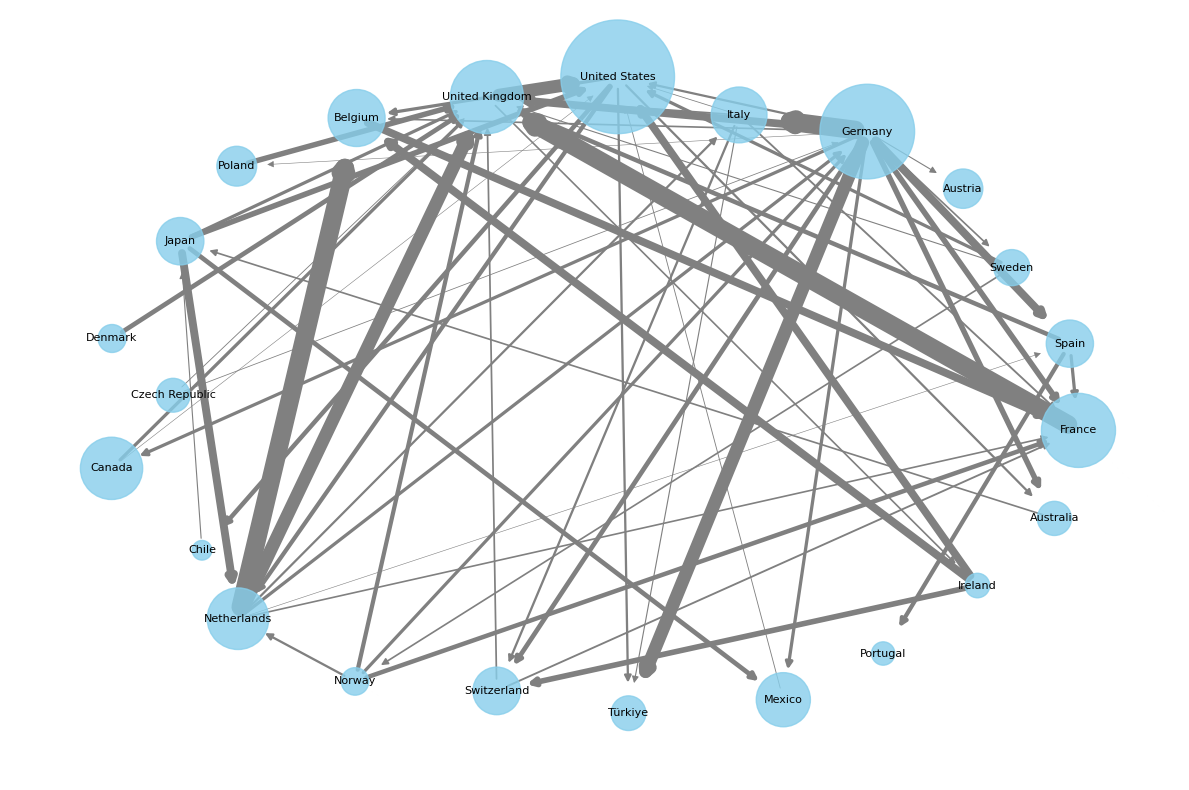

In [36]:
import numpy as np
from matplotlib import cm
from matplotlib.colors import LogNorm

# new edges w + net trade only
net_trade_edges = []
for u, v, data in g_trade.edges(data=True):
    weight_uv = data["weight"]
    weight_vu = g_trade[v][u]["weight"] if g_trade.has_edge(v, u) else 0
    net = weight_uv - weight_vu
    if net > 5000:  # only positive edges above threshold
        net_trade_edges.append((u, v, net))

g_net = nx.DiGraph()
g_net.add_weighted_edges_from(net_trade_edges)

# node sizes proportional to imports
node_sizes = [imports[n] / 180 for n in g_net.nodes()]  # adjust scaling

min_target_margin_value = np.sqrt(np.mean(node_sizes) / np.pi)

pos = nx.spring_layout(g_net, iterations=100, weight="weight", k=160)

plt.figure(figsize=(12, 8))

edge_sizes = [imports[n] / 90000 for n in g_net.nodes()]  # adjust scaling

# nodes
nx.draw_networkx_nodes(
    g_net, pos,
    node_color="skyblue",
    alpha=0.8,
    node_size=node_sizes
)

# edges
nx.draw_networkx_edges(
    g_net, pos,
    width=edge_sizes,
    edge_color="gray",
    arrows=True,
    min_source_margin=0,
    min_target_margin=min_target_margin_value
)

# labels
filtered_labels = {n: id2name[n] for n in g_net.nodes() if n in id2name}
nx.draw_networkx_labels(
    g_net, pos,
    labels=filtered_labels,
    font_color="black",
    font_size=8
)

plt.axis("off")
plt.tight_layout()
plt.show()


# 4. Comparison of export and import scores

In [38]:
import matplotlib.pyplot as plt

def plot_scatter(a, b, xlabel, ylabel, figsize=(20,10)):
    # filter zero values
    filtered_keys = [k for k in set(a.keys()).intersection(set(b.keys())) if a[k] > 0 and b[k] > 0]

    # prep values
    x_vals = [a[k] for k in filtered_keys]
    y_vals = [b[k] for k in filtered_keys]

    # make log-log plot
    plt.figure(figsize=figsize)
    plt.loglog(x_vals, y_vals, 'o', markersize=5)  # scatter points
    plt.xlabel(xlabel, {'size': '22'})
    plt.ylabel(ylabel, {'size': '22'})

    # add diagonal line
    min_val = min(min(x_vals), min(y_vals))
    max_val = max(max(x_vals), max(y_vals))
    plt.plot([min_val, max_val], [min_val, max_val], '-.', lw=2, color='gray')

    # annotate points
    for k in filtered_keys:
        plt.text(a[k], b[k], k, {'size': '12'})

    plt.show()


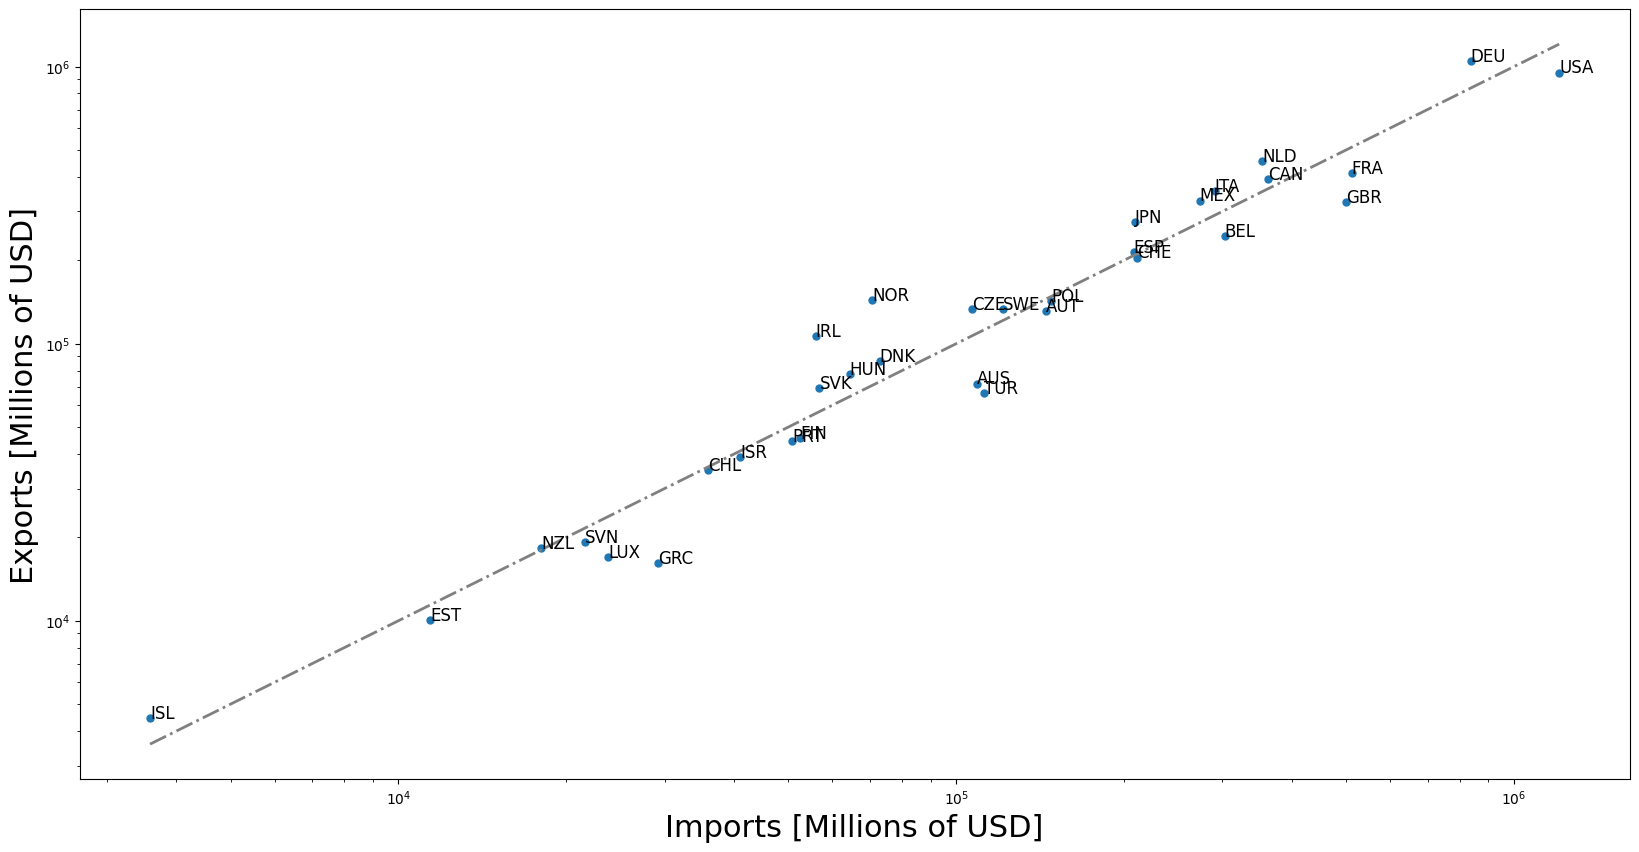

In [39]:
plot_scatter(imports, exports, "Imports [Millions of USD]", "Exports [Millions of USD]" )